In [5]:
import tensorflow as tf
import os
import numpy as np
import urllib


class CandleDataSet:

    def __init__(self, batch_size=256):
        self.batch_size = batch_size

    def prepare_data(self, ds):
        return ds.map(self.to_float32).map(self.reshape).cache().shuffle(1000).batch(self.batch_size).prefetch(32)

    def to_float32(self, value):
        return tf.cast(value, tf.float32)

    def reshape(self, value):
        return tf.reshape(value, (28, 28, 1))

    def get_data(self):
        category = 'candle'
        if not os.path.isdir('npy_files'):
            os.mkdir('npy_files')
        url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'
        urllib.request.urlretrieve(url, f'npy_files/{category}.npy')
        images = np.load(f'npy_files/{category}.npy')
        train_ds = tf.data.Dataset.from_tensor_slices(images)
        return train_ds.apply(self.prepare_data)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, \
    Rescaling, Dropout
import matplotlib.pyplot as plt


class GAN:

    def __init__(self, generator_learning_rate=0.0001, discriminator_learning_rate=0.0001):
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.generator.compile(optimizer=tf.keras.optimizers.Adam(generator_learning_rate))
        self.discriminator.compile(optimizer=tf.keras.optimizers.Adam(discriminator_learning_rate))

    @tf.function
    def train_step(self, data_set):
        generator_losses = 0.0
        discriminator_losses = 0.0
        for data in data_set:
            with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
                batch_size = tf.shape(data)[0]
                noise = self.generator(tf.random.normal([batch_size, self.generator.input_size]))
                fake_data_pred = self.discriminator(noise, True)
                real_data_pred = self.discriminator(data, True)
                loss_fun = tf.keras.losses.BinaryCrossentropy()
                generator_loss = loss_fun(tf.ones_like(fake_data_pred), fake_data_pred)
                discriminator_loss = (loss_fun(tf.ones_like(real_data_pred), real_data_pred) + loss_fun(
                    tf.zeros_like(fake_data_pred), fake_data_pred))
            discriminator_gradients = discriminator_tape.gradient(discriminator_loss,
                                                                  self.discriminator.trainable_variables)
            self.discriminator.optimizer.apply_gradients(
                zip(discriminator_gradients, self.discriminator.trainable_variables))
            generator_gradients = generator_tape.gradient(generator_loss, self.generator.trainable_variables)
            self.generator.optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
            generator_losses += generator_loss
            discriminator_losses += discriminator_loss
        return generator_losses, discriminator_losses

    def train(self, data_set, num_epochs=100):
        self.show_example_img()
        for epoch in range(num_epochs):
            generator_loss, discriminator_loss = self.train_step(data_set)
            batches = float(data_set.__len__())
            print(
                f"epoch {epoch}, generator_loss={generator_loss / batches}, discriminator_loss={discriminator_loss / batches}")
            self.show_example_img()

    def show_example_img(self):
        b = self.generator(tf.random.normal([1, self.generator.input_size]))
        plt.imshow(b[0].numpy().astype("uint8")[:, :, 0], cmap='gray')
        plt.show()


class Discriminator(tf.keras.Model):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.scaling = Rescaling(1. / 127.5, offset=-1)
        self.conv_layer1 = Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.conv_layer1 = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        self.dropout1 = Dropout(0.2)
        self.conv_layer2 = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.conv_layer2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        self.dropout2 = Dropout(0.2)
        self.conv_layer3 = Conv2D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.conv_layer3 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        self.dropout3 = Dropout(0.2)
        self.flatten = Flatten()
        self.out = Dense(1, activation=tf.nn.sigmoid)  # activation=None)

    @tf.function
    def call(self, inputs, is_training=False):
        x = self.scaling(inputs)
        x = self.conv_layer1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv_layer2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv_layer3(x)
        x = self.dropout3(x, training=is_training)
        x = self.flatten(x)
        return self.out(x)


class Generator(tf.keras.Model):

    def __init__(self):
        super(Generator, self).__init__()
        self.input_size = 100
        self.dense = Dense(7 * 7 * 256)
        self.reshape = Reshape((7, 7, 256))
        self.b_norm1 = BatchNormalization()
        self.activation1 = Activation(activation=tf.nn.relu)
        self.conv1 = Conv2D(filters=256, kernel_size=3, padding='same')
        self.b_norm2 = BatchNormalization()
        self.activation2 = Activation(activation=tf.nn.relu)
        self.conv_t1 = Conv2DTranspose(filters=128, kernel_size=4, padding='same', strides=2)
        self.conv2 = Conv2D(filters=128, kernel_size=3, padding='same')
        self.b_norm3 = BatchNormalization()
        self.activation3 = Activation(activation=tf.nn.relu)
        self.conv_t2 = Conv2DTranspose(filters=64, kernel_size=4, padding='same', strides=2)
        self.conv3 = Conv2D(filters=64, kernel_size=3, padding='same')
        self.b_norm4 = BatchNormalization()
        self.activation4 = Activation(activation=tf.nn.relu)
        self.conv = Conv2D(filters=1, kernel_size=3, padding='same', activation=tf.nn.sigmoid)  # activation=tf.nn.tanh
        self.out = Rescaling(255)

    @tf.function
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.b_norm1(x)
        x = self.activation1(x)
        x = self.conv1(x)
        x = self.b_norm2(x)
        x = self.activation2(x)
        x = self.conv_t1(x)
        x = self.conv2(x)
        x = self.b_norm3(x)
        x = self.activation3(x)
        x = self.conv_t2(x)
        x = self.conv3(x)
        x = self.b_norm4(x)
        x = self.activation4(x)
        x = self.conv(x)
        x = self.out(x)
        return x

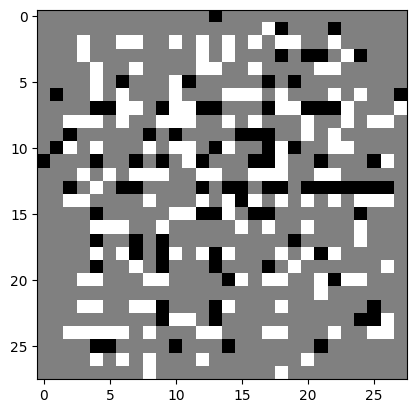

epoch 0, generator_loss=1.9400248527526855, discriminator_loss=1.090484857559204


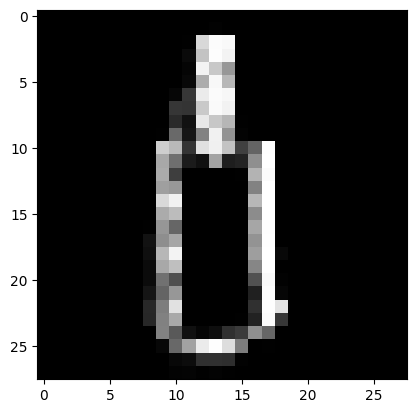

epoch 1, generator_loss=1.6464892625808716, discriminator_loss=1.039373517036438


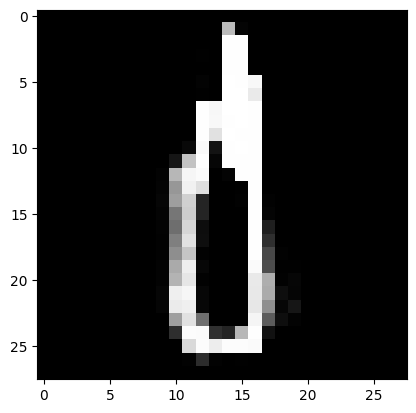

epoch 2, generator_loss=1.1904103755950928, discriminator_loss=1.0349935293197632


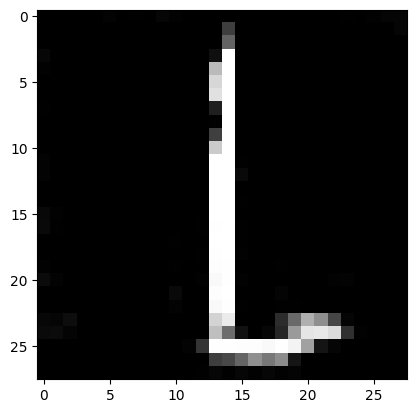

epoch 3, generator_loss=2.042023181915283, discriminator_loss=0.7175994515419006


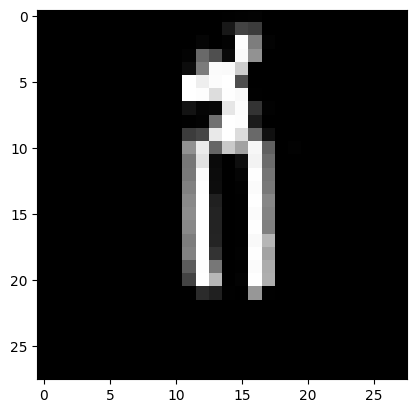

epoch 4, generator_loss=2.1584599018096924, discriminator_loss=0.6523434519767761


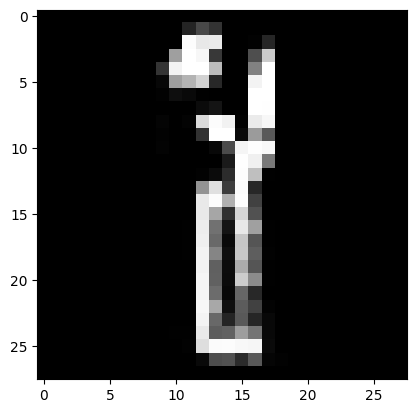

epoch 5, generator_loss=2.2427995204925537, discriminator_loss=0.5563575625419617


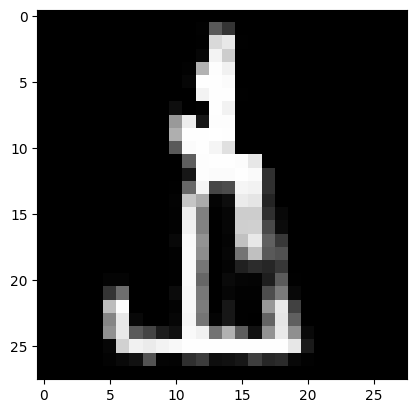

epoch 6, generator_loss=2.8457083702087402, discriminator_loss=0.4461786150932312


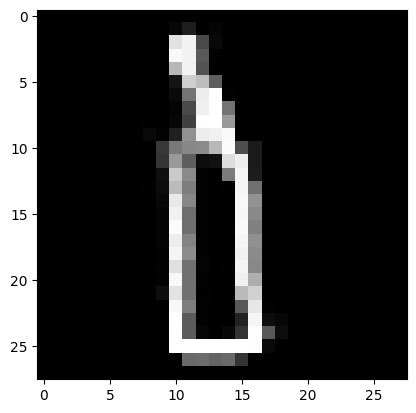

epoch 7, generator_loss=3.0351040363311768, discriminator_loss=0.3925013244152069


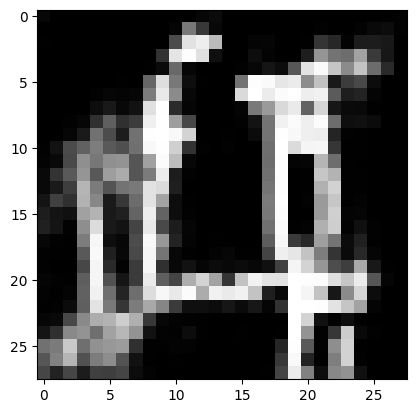

epoch 8, generator_loss=3.0995614528656006, discriminator_loss=0.4214403033256531


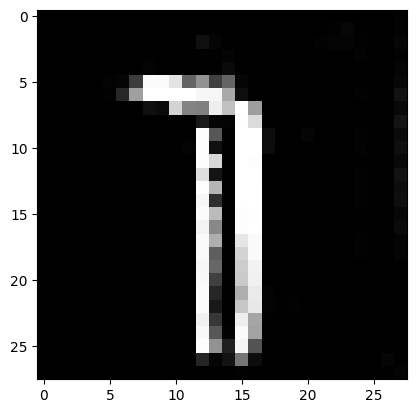

epoch 9, generator_loss=3.2254793643951416, discriminator_loss=0.3783738315105438


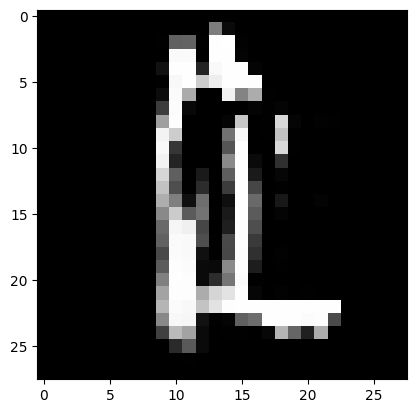

epoch 10, generator_loss=3.5488884449005127, discriminator_loss=0.34892550110816956


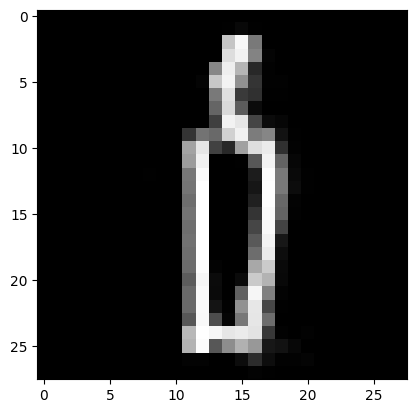

epoch 11, generator_loss=3.742462158203125, discriminator_loss=0.32034292817115784


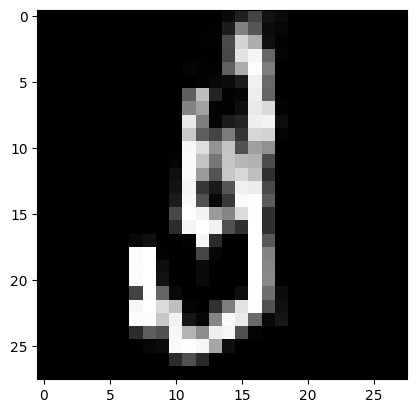

epoch 12, generator_loss=4.205031394958496, discriminator_loss=0.2646622061729431


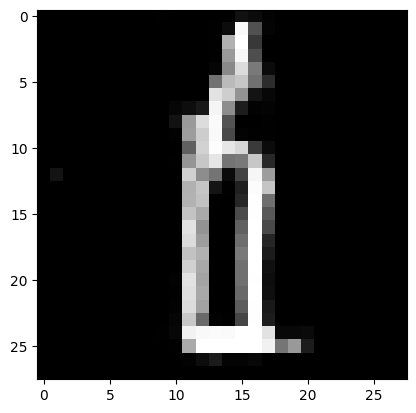

In [ ]:
# from GAN import GAN
# from CandleDataSet import CandleDataSet

ds = CandleDataSet(batch_size=32)
train_dataset = ds.get_data()

model = GAN()
model.train(train_dataset, 50)